# Imports

## Libraries

In [1]:
import random #can delete thsi when have sosas csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Functions

In [4]:
#### ?
# check if can have log loss for training and if it's ok to do it like this for train and test data

In [5]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))

    df_model_train = pd.DataFrame({'data'        : 'training',
                             'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : 'N/A'})
    
    accuracy     = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model_test = pd.DataFrame({'data'        : 'test',
                             'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss]})   # timetaken: to be used for comparison later
    
    df_model = pd.concat([df_model_train, df_model_test])

    return df_model

In [6]:
def plot_feature_importances(model, df):
    names = df.columns[model.feature_importances_.argsort()]
    model.feature_importances_.sort()
    plt.figure(figsize=(15,15))
    n_features = len(names)
    plt.barh(range(n_features), np.sort(model.feature_importances_), align='center')
    plt.yticks(np.arange(n_features), names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## Data

In [7]:
# Importing clean dataframe (with NaNs filled)

#df = pd.read_csv('data/xx.csv')

In [8]:
###### To delete this step when have the dataframe from sosa

# since don't have yeat the real df, will upload the old one

df = pd.read_csv('data/clean_tf.csv')

df = df.fillna(method='ffill')
df = df.drop('Unnamed: 0', axis=1)

rand = [random.random() for i in range(len(df))]
df['random'] = rand

In [9]:
# Checking if imported data is correct

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,AnyPage,Visitor_isReturning,random
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,1.0,1.0,1.0,Returning_Visitor,0.0,False,1.0,1.0,0.119733
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,2.0,2.0,1.0,2.0,Returning_Visitor,0.0,False,2.0,1.0,0.746880
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,4.0,1.0,9.0,3.0,Returning_Visitor,0.0,False,1.0,1.0,0.250035
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,3.0,2.0,2.0,4.0,Returning_Visitor,0.0,False,2.0,1.0,0.532047
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,99.0,1.0,4.0,Returning_Visitor,1.0,False,10.0,1.0,0.876952


In [10]:
# Checking the types of the variables

df.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems           float64
Browser                    float64
Region                     float64
TrafficType                float64
VisitorType                 object
Weekend                    float64
Revenue                       bool
AnyPage                    float64
Visitor_isReturning        float64
random                     float64
dtype: object

# Prepare Training Data

##TODO:
Make function that works with different train-test, different scaling, and different balancing
Output: Descriptive dataframe

## Data Encoding

We're encoding categorical variables to be able to use them in the models of the machine learning.


### Label Encoder

Using Label Encoder for the columns Revenue and Weekend because these columns have only two categories.

In [11]:
# Creating the instance of labelencoder
labelencoder = LabelEncoder()

# Assigning the columns
cols_label_enc = ['Revenue', 'Weekend']

# Creating labels for the columns
for col in cols_label_enc:
    df[col+'_enc'] = labelencoder.fit_transform(df[col])

### OneHotEncoder

We are using OneHotEncoder for Month, OperatingSystems, Region, TrafficType and Browser columns because they have more than two categories.

In [12]:
appended_dfs = []

columns = ['Month', 'OperatingSystems', 'Region', 'Browser', 'TrafficType']

for col in columns:
    # Creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # Passing columns
    enc_df = pd.DataFrame(enc.fit_transform(df[[col]]).toarray())
    # Getting values for the names of the columns
    enc_df.columns = enc.get_feature_names()+col
    # Appenign all new dfs to one list
    appended_dfs.append(enc_df)
# Mergeing with the main df
df_encoded = df.join(appended_dfs) 
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,x0_4.0TrafficType,x0_5.0TrafficType,x0_6.0TrafficType,x0_8.0TrafficType,x0_9.0TrafficType,x0_10.0TrafficType,x0_11.0TrafficType,x0_13.0TrafficType,x0_20.0TrafficType,x0_99.0TrafficType
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Deleting the columns that were encoded:

In [13]:
cols_drop = ['Revenue', 'Weekend', 'Month', 'OperatingSystems', 'Region', 'Browser', 'TrafficType', 'VisitorType']
df_encoded.drop(columns=cols_drop, inplace=True)

In [14]:
# Checking if the data is encoded correctly

df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,x0_4.0TrafficType,x0_5.0TrafficType,x0_6.0TrafficType,x0_8.0TrafficType,x0_9.0TrafficType,x0_10.0TrafficType,x0_11.0TrafficType,x0_13.0TrafficType,x0_20.0TrafficType,x0_99.0TrafficType
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,64.000000,0.20,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df_encoded.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
AnyPage                    float64
Visitor_isReturning        float64
random                     float64
Revenue_enc                  int64
Weekend_enc                  int64
x0_AugMonth                float64
x0_DecMonth                float64
x0_FebMonth                float64
x0_JulMonth                float64
x0_JuneMonth               float64
x0_MarMonth                float64
x0_MayMonth                float64
x0_NovMonth                float64
x0_OctMonth                float64
x0_SepMonth                float64
x0_1.0OperatingSystems     float64
x0_2.0OperatingSystems     float64
x0_3.0OperatingSystems     float64
x0_4.0OperatingSyste

### Exporting encoded data to csv

In [16]:
df_encoded.to_csv("data/df_encoded.csv", index=True)

## Data Split

Splitting data to: <br> X - independent variables <br> y - dependent variable (outcome) <br><br>Eliminating PageValues from the independent variables because it is too dependent on the outcome, it will not be possible to use it in the prediction.

Original dataset shape X: 12330, y: 12330
Original split between True and False:
0    10422
1     1908
Name: Revenue_enc, dtype: int64


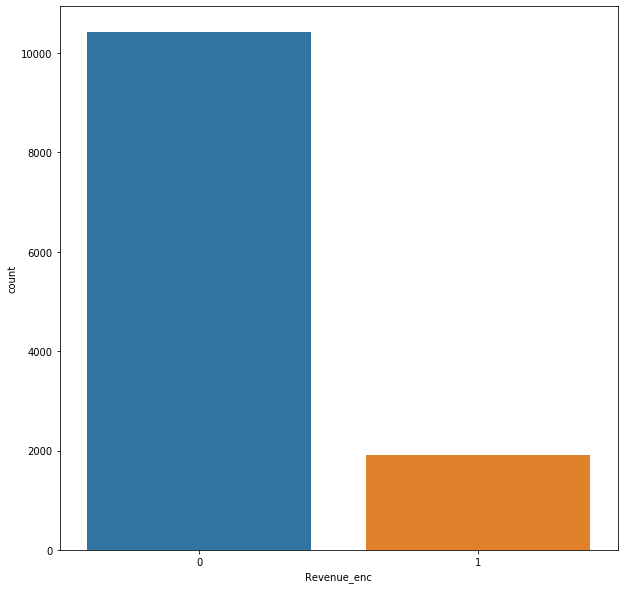

In [17]:
X = df_encoded.drop(columns=['Revenue_enc', 'PageValues'])
y = df_encoded['Revenue_enc']

print(f'Original dataset shape X: {len(X)}, y: {len(y)}')
print(f'Original split between True and False:\n{y.value_counts()}')

sns.countplot(y)
plt.show()

## Data Balancing (Undersampling)

As identified in the EDA in the previous step, we have a problem of our data being imbalanced. We will use the Undersample method which is the most conveniant for our dataset.

### NearMiss

In [18]:
#### Explain why NearMiss

Resampled dataset shape X: 3816, Y: 3816
Resampled split between True and False:
1    1908
0    1908
dtype: int64


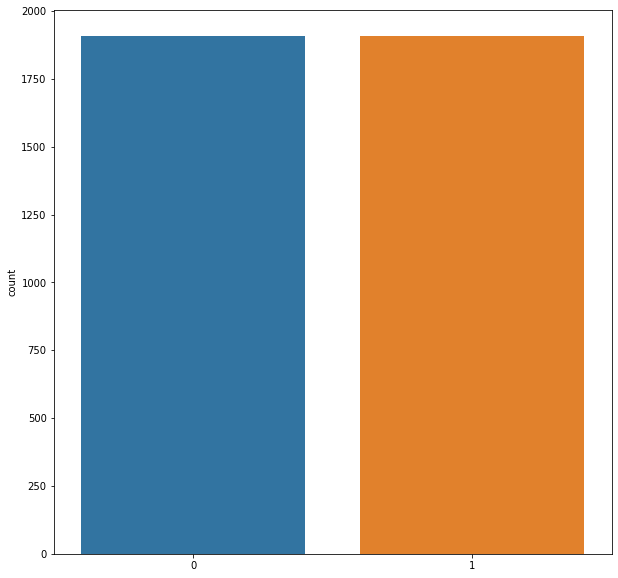

In [19]:
nr = NearMiss()
X, y = nr.fit_sample(X, y)

print(f'Resampled dataset shape X: {len(X)}, Y: {len(y)}')
print(f'Resampled split between True and False:\n{pd.Series(y).value_counts()}')

sns.countplot(y)
plt.show()

## Selecting test and train data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=41)

We define the train and test data in X training values and y target column.

- With shuffle, we set whether or not to shuffle the data before splitting (Default True).
- With stratify, we choose to split the data stritifying via labels (Default None).

# Scaling

Scaling allows us to standarize the numerical values of our dataset, centering to the mean.

## StandardScaler

In [21]:
std_scale = StandardScaler()

X_train = std_scale.fit_transform(X_train)
X_test = std_scale.transform(X_test)

# Modeling

## K-Nearest Neighbors

K-Nearest Neighbors (kNN) is an algorithm by which an unclassified data point is classified based on it’s distance from known points.

The way that model decides how to classify the unknown point is by creating a circle with the point as the center. The size of the circle is set by choosing the number of neighbors. This setting does not refer to the actual size of the circle, however, it refers to how many neighboring points are to fall inside of the circle.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

y_pred_test = knn.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
knn_results = baseline_report(knn, X_train, X_test, y_train, y_test, 'KNeighborsClassifier')
knn_results

Confussion Matrix for test data:
[[465 108]
 [143 429]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       573
           1       0.80      0.75      0.77       572

    accuracy                           0.78      1145
   macro avg       0.78      0.78      0.78      1145
weighted avg       0.78      0.78      0.78      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.758138,0.788030,0.702116,0.744057,0.818009,N/A
0,test,KNeighborsClassifier,0.756420,0.777193,0.723738,0.752562,0.829552,7.57146


In [23]:
# Explain results

### Hyperparameter Tuning

We will focus our hyperparameter tuning to optimize the **F1_score**. When optimizing for F1_score you take both precision and recall into account. If you try to only optimize recall, your algorithm will predict most examples to belong to the positive class, but that will result in many false positives and, hence, low precision. On the other hand, if you try to optimize precision, your model will predict very few examples as positive results (the ones which highest probability), but recall will be very low.

We will be using a GridSearchCV method, it's exostive and would be difficult to run on big datasets, but in our case it will work very well. Like that we will evaluate all possible cases of different parameter values and will find the best selection.

##### GridSearchCV

A note on the number of neighbors: It's best to choose the odd number for the n_neighbors. You can choose an even number, but in the case of a tie vote, the decision on which class to assign will be done randomly when weights is set to uniform. By choosing an odd number, there are no ties.

Another thing to mention is that n_jobs = -1. By setting n_jobs to -1, you’re telling the computer to use all of it’s processors to perform the model.

In [24]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19],
              'weights': ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)

best_params_knn = grid.best_params_
print(best_params_knn)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s


{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.2s finished


The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [25]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
knn_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'KNeighborsClassifier')
knn_results_hyp

Confussion Matrix for test data:
[[529  44]
 [129 443]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       573
           1       0.91      0.77      0.84       572

    accuracy                           0.85      1145
   macro avg       0.86      0.85      0.85      1145
weighted avg       0.86      0.85      0.85      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.836018,0.903785,0.755255,0.826008,0.927513,N/A
0,test,KNeighborsClassifier,0.861179,0.907146,0.779756,0.842796,0.945843,5.21855


In [26]:
# Explain Results

## Logistic Regression

In [27]:
#description

In [28]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_test = logreg.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
logreg_results = baseline_report(logreg, X_train, X_test, y_train, y_test, 'LogisticRegression')
logreg_results

Confussion Matrix for test data:
[[554  19]
 [ 37 535]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       573
           1       0.97      0.94      0.95       572

    accuracy                           0.95      1145
   macro avg       0.95      0.95      0.95      1145
weighted avg       0.95      0.95      0.95      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LogisticRegression,0.925114,0.944937,0.901210,0.926716,0.979619,N/A
0,test,LogisticRegression,0.940610,0.948090,0.930114,0.931206,0.984157,1.68925


In [29]:
# Explain results

### Hyperparameter Tuning

##### GridSearchCV

In [30]:
c_values = list(10.0**np.arange(-3, 3))

param_grid = [{'C': c_values,
              'penalty': ['l2'],
              'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              'multi_class': ['ovr', 'warn']},
              {'C': c_values,
              'penalty': ['l1'],
              'solver' : ['liblinear'],
              'multi_class': ['ovr', 'warn']}]

grid = GridSearchCV(LogisticRegression(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)

best_params_logreg = grid.best_params_
print(best_params_logreg)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'multi_class': 'warn', 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    3.7s finished


The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [31]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
logreg_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'LogisticRegression')
logreg_results_hyp

Confussion Matrix for test data:
[[556  17]
 [ 40 532]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       573
           1       0.97      0.93      0.95       572

    accuracy                           0.95      1145
   macro avg       0.95      0.95      0.95      1145
weighted avg       0.95      0.95      0.95      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LogisticRegression,0.930730,0.955029,0.900439,0.926204,0.980720,N/A
0,test,LogisticRegression,0.947628,0.958707,0.929992,0.937056,0.987171,1.71941


In [32]:
# Explain Results

## Decision Tree

In [33]:
# Description

In [34]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)

y_pred_test = dectree.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
dectree_results = baseline_report(dectree, X_train, X_test, y_train, y_test, 'DecisionTreeClassifier')
dectree_results

Confussion Matrix for test data:
[[527  46]
 [ 48 524]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       573
           1       0.92      0.92      0.92       572

    accuracy                           0.92      1145
   macro avg       0.92      0.92      0.92      1145
weighted avg       0.92      0.92      0.92      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,DecisionTreeClassifier,0.902284,0.899654,0.904195,0.905170,0.908277,N/A
0,test,DecisionTreeClassifier,0.906560,0.918170,0.923005,0.920744,0.905629,2.6847


### Feature importance

We're will be using a defined function to visualize the most important features:

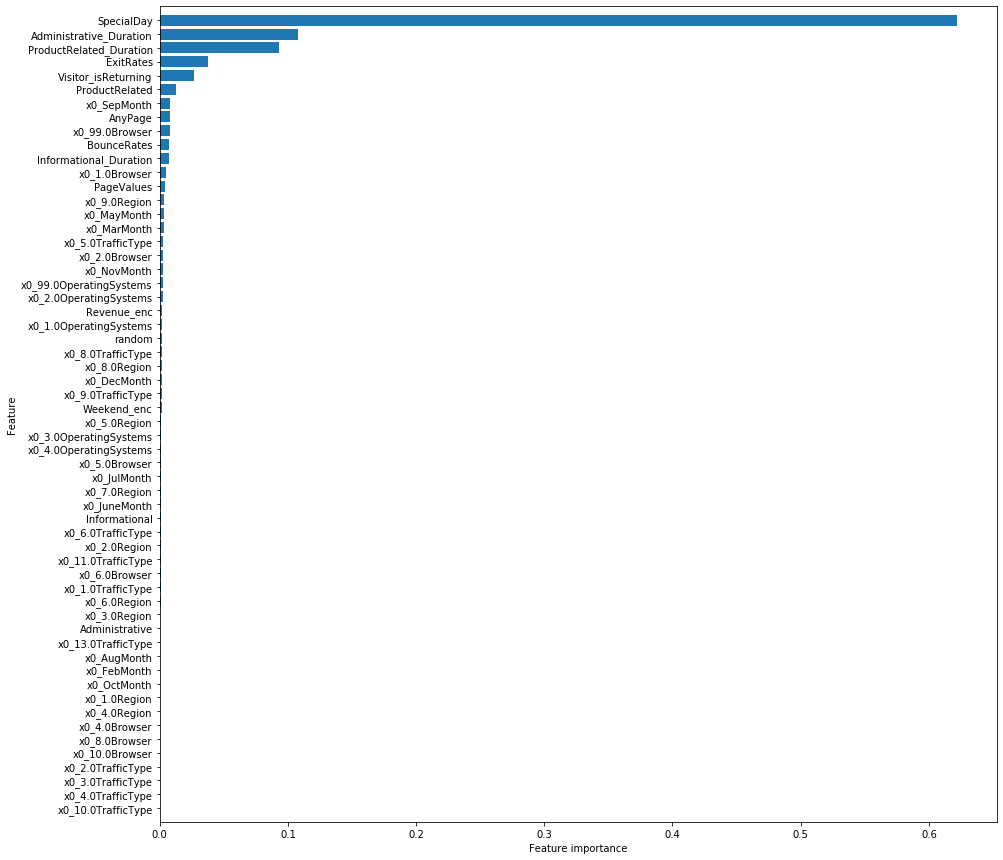

In [35]:
plot_feature_importances(dectree, df_encoded)
plt.savefig('feature_importance_dectree')

In [36]:
# Explain results

### Hyperparameter Tuning

##### GridSearchCV

Parameters that we will be checking:

**criterion** : optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

**splitter** : string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

**max_depth** : int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting

In [37]:
depth = list(np.arange(2, 10))

param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth' : depth}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_dectree = grid.best_params_
print(best_params_dectree)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.2s finished


The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [38]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
dectree_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'DecisionTreeClassifier')
dectree_results_hyp

Confussion Matrix for test data:
[[554  19]
 [ 44 528]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       573
           1       0.97      0.92      0.94       572

    accuracy                           0.94      1145
   macro avg       0.95      0.94      0.94      1145
weighted avg       0.95      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,DecisionTreeClassifier,0.913520,0.934323,0.892249,0.922020,0.957374,N/A
0,test,DecisionTreeClassifier,0.929272,0.945803,0.909062,0.927258,0.953053,2.08139


In [39]:
# Explain Results

## Random Forest

In [40]:
# Description

In [41]:
from sklearn.ensemble import RandomForestClassifier

rfor = RandomForestClassifier()
rfor.fit(X_train, y_train)

y_pred_test = rfor.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
rfor_results = baseline_report(rfor, X_train, X_test, y_train, y_test, 'RandomForestClassifier')
rfor_results

Confussion Matrix for test data:
[[556  17]
 [ 36 536]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       573
           1       0.97      0.94      0.95       572

    accuracy                           0.95      1145
   macro avg       0.95      0.95      0.95      1145
weighted avg       0.95      0.95      0.95      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,RandomForestClassifier,0.924748,0.955070,0.911697,0.928622,0.976262,N/A
0,test,RandomForestClassifier,0.933631,0.955938,0.910908,0.932232,0.982424,1.87024


### Feature importance

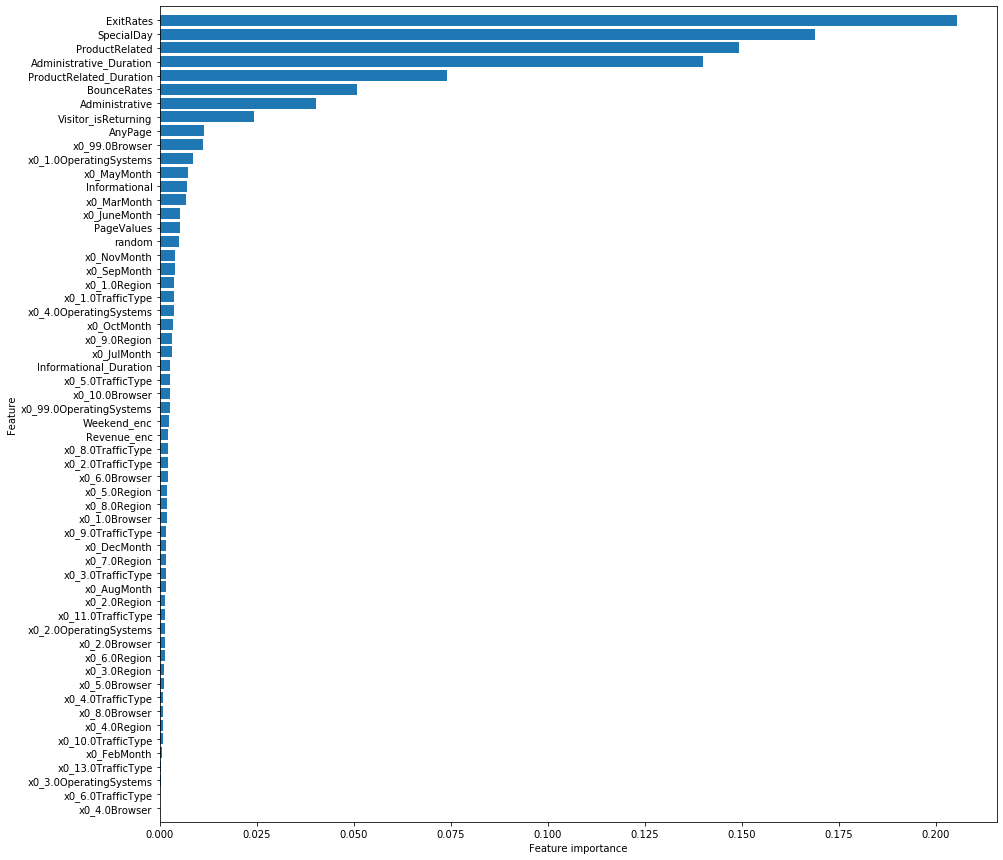

In [42]:
plot_feature_importances(rfor, df_encoded)
plt.savefig('feature_importance_rfor')

In [43]:
# Explain results

# can choose to split where we see elbow or after random

#strange that anypage has such a low performance, while each page alone have higher.
#check if it's done ok, if it's not redundant info
#check what we put under browser 99 when did transformation, why other has higher importance??

#explanation of alberto, to change
#Similarly to the single decision tree, the random forest also gives a lot of importance to the “Glucose” feature, but it also chooses “BMI” to be the 2nd most informative feature overall. The randomness in building the random forest forces the algorithm to consider many possible explanations, the result being that the random forest captures a much broader picture of the data than a single tree.

### Hyperparameter Tuning

##### GridSearchCV

In [45]:
param_grid = {'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' :['gini', 'entropy']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_rfor = grid.best_params_
print(best_params_rfor)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.5s finished


{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [46]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
rfor_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'RandomForestClassifier')
rfor_results_hyp

Confussion Matrix for test data:
[[554  19]
 [ 44 528]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       573
           1       0.97      0.92      0.94       572

    accuracy                           0.94      1145
   macro avg       0.95      0.94      0.94      1145
weighted avg       0.95      0.94      0.94      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,RandomForestClassifier,0.932981,0.954030,0.915420,0.931715,0.983852,N/A
0,test,RandomForestClassifier,0.943265,0.957067,0.924836,0.941493,0.989188,1.9909


In [47]:
# Explain results

## Linear Support Vector Classification

In [48]:
# Description

In [49]:
from sklearn.svm import LinearSVC

linearsvc = LinearSVC()
linearsvc.fit(X_train, y_train)

y_pred_test = linearsvc.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
linearsvc_results = baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')
linearsvc_results

Confussion Matrix for test data:
[[554  19]
 [ 42 530]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       573
           1       0.97      0.93      0.95       572

    accuracy                           0.95      1145
   macro avg       0.95      0.95      0.95      1145
weighted avg       0.95      0.95      0.95      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LinearSVC,0.929615,0.946886,0.910951,0.928851,0.981265,N/A
0,test,LinearSVC,0.941484,0.946716,0.926529,0.941761,0.986600,1.84007


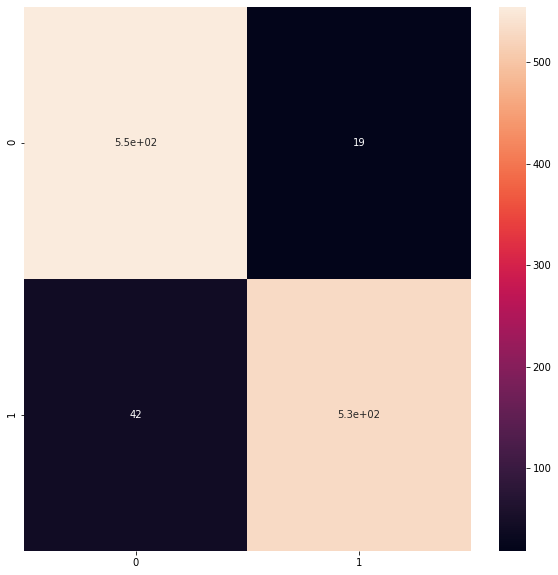

In [50]:
# Visualizing results

sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)
plt.show()

In [51]:
# Explain results

### Hyperparameter Tuning

##### GridSearchCV

In [53]:
c_values = list(10.0**np.arange(-3, 3))

param_grid = [{'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l1'],
              'loss': ['squared_hinge'],
              'dual': [0]},
              {'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l2'],
              'loss': ['squared_hinge'],
              'dual': [1]}]

grid = GridSearchCV(LinearSVC(), param_grid, verbose=1, cv=3, n_jobs=-1, scoring='f1')                 
grid.fit(X_train, y_train)  

best_params_linearsvc = grid.best_params_
print(best_params_linearsvc)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'dual': 0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   22.8s finished


The second step is to evaluate our model with the selection of the best parameters and see the impact on the scores.

In [54]:
y_pred_test = grid.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
linearsvc_results_hyp = baseline_report(grid.best_estimator_, X_train, X_test, y_train, y_test, 'LinearSVC')
linearsvc_results_hyp

Confussion Matrix for test data:
[[558  15]
 [ 41 531]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       573
           1       0.97      0.93      0.95       572

    accuracy                           0.95      1145
   macro avg       0.95      0.95      0.95      1145
weighted avg       0.95      0.95      0.95      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,LinearSVC,0.927367,0.947794,0.905693,0.925089,0.981464,N/A
0,test,LinearSVC,0.943253,0.963548,0.928360,0.944000,0.989133,1.68924


In [55]:
# Explain results

## Gaussian Naive Bayes

In [56]:
# Description

In [57]:
from sklearn.naive_bayes import GaussianNB

naive_b = GaussianNB()
naive_b.fit(X_train, y_train)

y_pred_test = naive_b.predict(X_test)

print(f'Confussion Matrix for test data:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'\nClassification report for test data:\n{classification_report(y_test, y_pred_test)}')
naive_b_results = baseline_report(naive_b, X_train, X_test, y_train, y_test, 'GaussianNB')
naive_b_results

Confussion Matrix for test data:
[[566   7]
 [ 69 503]]

Classification report for test data:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       573
           1       0.99      0.88      0.93       572

    accuracy                           0.93      1145
   macro avg       0.94      0.93      0.93      1145
weighted avg       0.94      0.93      0.93      1145



,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,GaussianNB,0.912391,0.949643,0.857798,0.904500,0.971127,N/A
0,test,GaussianNB,0.937971,0.969079,0.910831,0.935038,0.978320,2.29254


In [58]:
# Explain results

### Hyperparameter Tuning

We will not be performing hyperparameter tuning because GaussianNB does not have any adjustable hyperparameters.

## Final model evaluation

Results before hyperparameter tuning:

In [59]:
before_hyp = [knn_results, logreg_results, dectree_results, rfor_results, 
              linearsvc_results, naive_b_results]

final_results_before = pd.concat(before_hyp)
final_results_before

,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.758138,0.788030,0.702116,0.744057,0.818009,N/A
0,test,KNeighborsClassifier,0.756420,0.777193,0.723738,0.752562,0.829552,7.57146
0,training,LogisticRegression,0.925114,0.944937,0.901210,0.926716,0.979619,N/A
0,test,LogisticRegression,0.940610,0.948090,0.930114,0.931206,0.984157,1.68925
0,training,DecisionTreeClassifier,0.902284,0.899654,0.904195,0.905170,0.908277,N/A
0,test,DecisionTreeClassifier,0.906560,0.918170,0.923005,0.920744,0.905629,2.6847
0,training,RandomForestClassifier,0.924748,0.955070,0.911697,0.928622,0.976262,N/A
0,test,RandomForestClassifier,0.933631,0.955938,0.910908,0.932232,0.982424,1.87024
0,training,LinearSVC,0.929615,0.946886,0.910951,0.928851,0.981265,N/A
0,test,LinearSVC,0.941484,0.946716,0.926529,0.941761,0.986600,1.84007


Results after hyperparameter tuning:

In [60]:
after_hyp = [knn_results_hyp, logreg_results_hyp, dectree_results_hyp, rfor_results_hyp, 
              linearsvc_results_hyp]

final_results_after = pd.concat(after_hyp)
final_results_after

,data,model,accuracy,precision,recall,f1score,rocauc,logloss
0,training,KNeighborsClassifier,0.836018,0.903785,0.755255,0.826008,0.927513,N/A
0,test,KNeighborsClassifier,0.861179,0.907146,0.779756,0.842796,0.945843,5.21855
0,training,LogisticRegression,0.930730,0.955029,0.900439,0.926204,0.980720,N/A
0,test,LogisticRegression,0.947628,0.958707,0.929992,0.937056,0.987171,1.71941
0,training,DecisionTreeClassifier,0.913520,0.934323,0.892249,0.922020,0.957374,N/A
0,test,DecisionTreeClassifier,0.929272,0.945803,0.909062,0.927258,0.953053,2.08139
0,training,RandomForestClassifier,0.932981,0.954030,0.915420,0.931715,0.983852,N/A
0,test,RandomForestClassifier,0.943265,0.957067,0.924836,0.941493,0.989188,1.9909
0,training,LinearSVC,0.927367,0.947794,0.905693,0.925089,0.981464,N/A
0,test,LinearSVC,0.943253,0.963548,0.928360,0.944000,0.989133,1.68924


## Notes

In [62]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [63]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', error_score='raise-deprecating', return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |     

In [64]:
# get cross validation dataframe
grid.cv_results_
hyp_res = pd.DataFrame(grid.cv_results_)
hyp_res
hyp_res[['param_criterion', 'param_max_depth', 'param_max_features','param_n_estimators', 
         'mean_test_score']].sort_values('mean_test_score', ascending=False) 

KeyError: "['param_max_depth', 'param_criterion', 'param_n_estimators', 'param_max_features'] not in index"

In [ ]:
# check what else I can take from it

dir(grid)

In [ ]:
# The same cross validation done manually, check the difference with function

#Cross validation with best_estimator from grid search (using strat_k_fold, by default have kfold)

strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
initial_score = cross_val_score(grid.best_estimator_, X_test, y_test, cv=strat_k_fold, 
                                scoring='f1').mean()
print("Final accuracy : {} ".format(initial_score))

In [ ]:
# miltiple scoring, should give the same as function, check the difference in settings

from sklearn.model_selection import cross_validate

initial_score = cross_validate(grid.best_estimator_, X_test, y_test, cv=strat_k_fold, 
                               scoring=('f1', 'accuracy'))
print(initial_score['test_f1'].mean())
print(initial_score['test_accuracy'].mean())

In [ ]:
# info about scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# GridSearchCV has a very high computation cost if we want to try a bigger range of parameter values

In [ ]:
# RandomizedSearchCV to randomly try different parameters, but in our case the dataset is not 
#too big so we can allow to run gridsearch

In [ ]:
# hyperparameter for all models to find all best parameter values for all models 
# https://www.youtube.com/watch?v=HdlDYng8g9s